In [1]:
import gc
import bz2
import pickle
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
from sklearn.preprocessing import LabelEncoder

Download https://drive.google.com/drive/folders/1BZFez3OFs7QMzeDUz-8E0SgnRy227pnG

Unzip

!mkdir data
!tar -xf inno_stats.tar.gz -C ./data

In [3]:
data_path = Path('./data/').resolve()
!ls {data_path}

09_groups.csv  10_groups.csv  11_groups.csv  product_groups.csv


In [2]:
g_9 = pd.read_csv('./data/09_groups.csv')
g_9.head()

,date,id_doc,id_order,id_card,id_tov,id_kontr,quantity,sum,is_green,id_group
0,2020-09-01 17:01:25,1283228,0.0,1538855,52,271,1.0,108.00,0,10004
1,2020-09-01 17:35:36,8873113,0.0,267307,52,271,1.0,108.00,0,10004
2,2020-09-01 19:19:21,12712899,0.0,610220,52,271,1.0,107.95,0,10004
3,2020-09-01 21:53:34,21535283,0.0,441497,52,271,1.0,108.00,0,10004
4,2020-09-01 18:42:31,642341,0.0,1065358,61,97,2.0,88.00,0,10091


In [7]:
g_10 = pd.read_csv('./data/10_groups.csv')
g_10.head()

,date,id_doc,id_order,id_card,id_tov,id_kontr,quantity,sum,is_green,id_group
0,2020-10-01 20:22:55,2035558,0.0,1636749,52,339,1.0,107.90,0,10004
1,2020-10-01 20:54:12,13037327,0.0,267261,52,339,1.0,80.04,0,10004
2,2020-10-01 21:25:59,1430590,0.0,1331395,61,379,1.0,31.92,1,10091
3,2020-10-01 13:31:01,3504660,0.0,641525,61,97,1.0,55.98,0,10091
4,2020-10-01 16:32:06,11024438,0.0,1325852,61,97,4.0,176.00,0,10091


In [2]:
g_11 = pd.read_csv('./data/11_groups.csv')
g_11.head()

,date,id_doc,id_order,id_card,id_tov,id_kontr,quantity,sum,is_green,id_group
0,2020-11-01 15:29:01,3121751,0.0,332351,52,271,1.0,107.98,0,10004
1,2020-11-01 12:41:10,22047017,8293317.0,1875438,52,-9999,1.0,108.00,0,10004
2,2020-11-01 13:17:09,6419825,0.0,563112,61,379,2.0,112.00,0,10091
3,2020-11-01 12:31:31,10284541,0.0,1841710,61,379,1.0,55.91,0,10091
4,2020-11-01 13:06:15,10424967,0.0,1304277,61,271,2.0,87.80,0,10091


In [3]:
p_g = pd.read_csv('./data/product_groups.csv', delimiter=';', encoding='windows-1251')
p_g.head()

,id_tov,id_group,name_group
0,52,10004,Кисломолочные продукты
1,75,10004,Кисломолочные продукты
2,77,10004,Кисломолочные продукты
3,143,10004,Кисломолочные продукты
4,151,10004,Кисломолочные продукты


Load bad ids from bad_ids.csv file

In [4]:
bad_ids = pd.read_csv('bad_ids.csv')
bad_ids.head()

,Unnamed: 0,id_card
0,0,806096
1,1,1438102
2,2,72344
3,3,427981
4,4,1528414


Remove items with bad ids from the dataset. We'll be only using the first dataset ('09_groups.csv')

In [5]:
df = g_9[~g_9['id_card'].isin(set(bad_ids['id_card']))]

After removing the bad ids:

In [6]:
df.head()

,date,id_doc,id_order,id_card,id_tov,id_kontr,quantity,sum,is_green,id_group
0,2020-09-01 17:01:25,1283228,0.0,1538855,52,271,1.0,108.00,0,10004
1,2020-09-01 17:35:36,8873113,0.0,267307,52,271,1.0,108.00,0,10004
2,2020-09-01 19:19:21,12712899,0.0,610220,52,271,1.0,107.95,0,10004
3,2020-09-01 21:53:34,21535283,0.0,441497,52,271,1.0,108.00,0,10004
4,2020-09-01 18:42:31,642341,0.0,1065358,61,97,2.0,88.00,0,10091


## Task 1

Prove that buying discounted products depends on the average order sum. (It is more probable that the discounted product will be bought if bunch of money is going to be spend)

First we separate all orders into orders with discounted items and without discounted items

In [9]:
disc_all = df.groupby("id_doc")['is_green'].sum()
disc_all.head()

id_doc
2     0
4     0
5     0
16    0
18    0
Name: is_green, dtype: int64

In [21]:
disc_all_index = list(disc_all.index)
discounted = list(disc_all[disc_all != 0].index)
non_discounted = list(disc_all[disc_all == 0].index)
print(f'NO of all orders: {len(disc_all_index)}. No of order that contain discounted item: {len(discounted)}, without discounted item: {len(non_discounted)}')

NO of all orders: 6904825. No of order that contain discounted item: 1064042, without discounted item: 5840783


In [34]:
print(discounted[:10])
print(non_discounted[:10])

[19, 60, 76, 138, 152, 159, 181, 197, 232, 234]
[2, 4, 5, 16, 18, 26, 27, 30, 31, 32]


Next we find the average sum of the orders of these two groups:

In [37]:
avg_discounted = df[df['id_doc'].isin(set(discounted))].groupby('id_doc')['sum'].sum()
print(avg_discounted.head())
print(f'average: {avg_discounted.mean()}')

id_doc
19     200.0
60      54.6
76     114.6
138     93.0
152    187.6
Name: sum, dtype: float64
average: 603.6524604761845


In [41]:
avg_non_discounted = df[df['id_doc'].isin(set(non_discounted))].sample(n=len(discounted)).groupby('id_doc')['sum'].sum()
print(avg_non_discounted.head())
print(f'average: {avg_non_discounted.mean()}')

id_doc
4      54.0
50     37.0
57    182.0
77    411.0
91     66.0
Name: sum, dtype: float64
average: 138.24805665255903


**So the average sum of orders that contain discounted item is much larger than the average sum of orders without discounted items**

In [43]:
ttest_ind(avg_discounted, avg_non_discounted)

Ttest_indResult(statistic=731.3775857743642, pvalue=0.0)

## Task 2
Prove that the frequency of shopping grows around the wage taking days.

In [47]:
df.index = pd.to_datetime(df['date'],format='%Y-%m-%d %H:%M:%S')
quantity = df.groupby(by=[df.index.day])['id_doc'].sum()
quantity.head()

date
1    14889994585708
2    15086338489181
3    15056395236199
4    14856128854532
5    12345484570987
Name: id_doc, dtype: int64

In [48]:
print(quantity)

date
1     14889994585708
2     15086338489181
3     15056395236199
4     14856128854532
5     12345484570987
6     13537747597722
7     16041885335734
8     14371887787724
9     15671403072816
10    15271582488483
11    15026911912134
12    12745316239737
13    13714659797302
14    16058975513908
15    15440389529243
16    15527369226395
17    13792099678222
18    16729817070290
19    13646147244808
20    14099107055374
21    16033290143413
22    15836015572717
23    15704254868905
24    15585650512533
25    15953336106499
26    13235264885766
27    14297008042717
28    16592919621754
29    16491873929783
30    16567061417021
Name: id_doc, dtype: int64


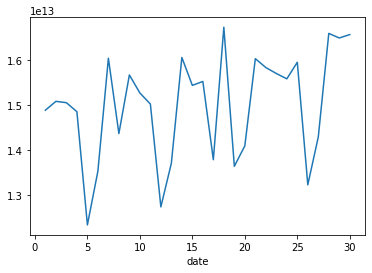

In [52]:
quantity.plot()
plt.show()

**From the plot above we can see that frequency of shopping increases around the wage taking days (1-5th and 20-26th of each month)**

## Task 3
Define such cohort existance:
1. Frequent buyers - The users that are shopping frequently(daily, weekly, monthly) 
2. Average purchase sum - The customers that usually spend the same amount of money 
3. Orders amount - The customers grouped by the total numer of orders 
4. Usual cart - The customers grouped by the product groups

References
- https://towardsdatascience.com/a-step-by-step-introduction-to-cohort-analysis-in-python-a2cbbd8460ea

### Frequent buyers

In [8]:
freq = df.groupby('id_card')['id_doc'].apply(len)

In [11]:
freq[freq > freq.mean()]

id_card
0           44
3           34
4           36
10         120
14          58
          ... 
1932576     44
1932583     49
1932649     35
1933385     35
1939417     64
Name: id_doc, Length: 411152, dtype: int64

### Average purchase sum

In [92]:
def funk(x):
    return int(x / 10)
aps = df.groupby(by=['id_doc', 'id_card'])['sum'].sum().apply(funk)

In [93]:
aps.head()

id_doc  id_card
2       1425208     39
4       1438933    159
5       293299      25
16      715970      70
18      74800       70
Name: sum, dtype: int64

In [97]:
print(list(aps.index)[:10])

[(2, 1425208), (4, 1438933), (5, 293299), (16, 715970), (18, 74800), (19, 948401), (26, 1530864), (27, 200044), (30, 773541), (31, 788119)]


In [107]:
d = {'id_doc': [x[0] for x in list(aps.index)], 'id_card': [x[1] for x in list(aps.index)], 'sum': list(aps)}
aps_df = pd.DataFrame(data=d).groupby('sum')['id_card'].apply(len)

In [108]:
aps_df.head()

sum
0     2758
1     7093
2    29833
3    39367
4    59558
Name: id_card, dtype: int64

### Orders amount

In [61]:
orders_amount = df.groupby('id_card')['id_doc'].unique().apply(len)

In [84]:
d = {'id_card': list(orders_amount.index), 'id_doc': list(orders_amount)}
cus_with_same_order = pd.DataFrame(data=d)

In [86]:
cus_with_same_order.groupby('id_doc')['id_card'].unique()

id_doc
1      [1, 2, 7, 9, 13, 18, 29, 40, 44, 58, 60, 62, 7...
2      [8, 21, 24, 33, 89, 111, 132, 148, 164, 206, 2...
3      [16, 69, 70, 107, 115, 126, 143, 157, 201, 228...
4      [39, 45, 97, 118, 147, 257, 346, 356, 368, 378...
5      [4, 154, 161, 204, 256, 285, 335, 353, 375, 39...
                             ...                        
103                                   [1144271, 1808366]
104                                            [1567258]
109                                             [943480]
119                                            [1523082]
161                                             [620767]
Name: id_card, Length: 89, dtype: object

In [87]:
cus_with_same_order.groupby('id_doc')['id_card'].unique().apply(len)

id_doc
1      406287
2      205028
3      135162
4       99732
5       77610
        ...  
103         2
104         1
109         1
119         1
161         1
Name: id_card, Length: 89, dtype: int64

### Usual cart

In [53]:
usual_cart = df.groupby('id_group')['id_card'].unique()

In [54]:
usual_cart.head()

id_group
-9999     [1672691, 82434, 954793, 1572538, 1408606, 683...
 10004    [1538855, 267307, 610220, 441497, 389692, 3110...
 10005    [31109, 511852, 1254751, 563773, 736602, 16969...
 10008    [1360897, 954793, 1841743, 626319, 389640, 924...
 10012    [1572538, 297933, 149795, 469039, 1318057, 172...
Name: id_card, dtype: object